In [40]:
import numpy as np 
import pandas as pd 
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import style
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime

In [41]:
#import keras
from keras.layers import Dense
from keras.models import Sequential
#from keras.layers import LSTM


In [42]:
df=pd.read_pickle("filteredDataAQ.pkl") 
df.head() 

,PM2.5,PM10,NO2,NH3,SO2,CO,AQI,datetime,Year,Month,Day,Weekday,Hour,TEMPERATURE,ALTITUDE,HUMIDITY
0,68,64,17,4,28,31,68,1/3/2020 10:00,2020,1,3,Friday,10,26,76,52
1,67,70,23,2,13,49,77,1/3/2020 10:00,2020,1,3,Friday,10,39,115,54
2,32,64,26,5,6,19,32,1/3/2020 10:00,2020,1,3,Friday,10,34,153,88
3,93,93,31,3,9,57,93,1/3/2020 10:00,2020,1,3,Friday,10,30,405,79
4,60,55,20,5,18,29,60,1/5/2020 6:00,2020,1,5,Sunday,6,27,102,72


In [43]:

# # mark all NA values with 0
df['AQI'].fillna(0, inplace=True)
df.head

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_12940\1426570994.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['AQI'].fillna(0, inplace=True)


<bound method NDFrame.head of       PM2.5  PM10  NO2  NH3  SO2  CO  AQI        datetime  Year  Month  Day  \
0        68    64   17    4   28  31   68  1/3/2020 10:00  2020      1    3   
1        67    70   23    2   13  49   77  1/3/2020 10:00  2020      1    3   
2        32    64   26    5    6  19   32  1/3/2020 10:00  2020      1    3   
3        93    93   31    3    9  57   93  1/3/2020 10:00  2020      1    3   
4        60    55   20    5   18  29   60   1/5/2020 6:00  2020      1    5   
...     ...   ...  ...  ...  ...  ..  ...             ...   ...    ...  ...   
1560    163   142   57    7   10  39  163   1/7/2020 3:00  2020      1    7   
1561    279   215   78   11   23  31  279   1/7/2020 3:00  2020      1    7   
1562    162   136   43    4   16  34  162   1/7/2020 3:00  2020      1    7   
1563    213   152   55    5   11  95  213   1/7/2020 3:00  2020      1    7   
1564    199   166   60    7    6  29  199   1/7/2020 3:00  2020      1    7   

      Weekday  Hour  

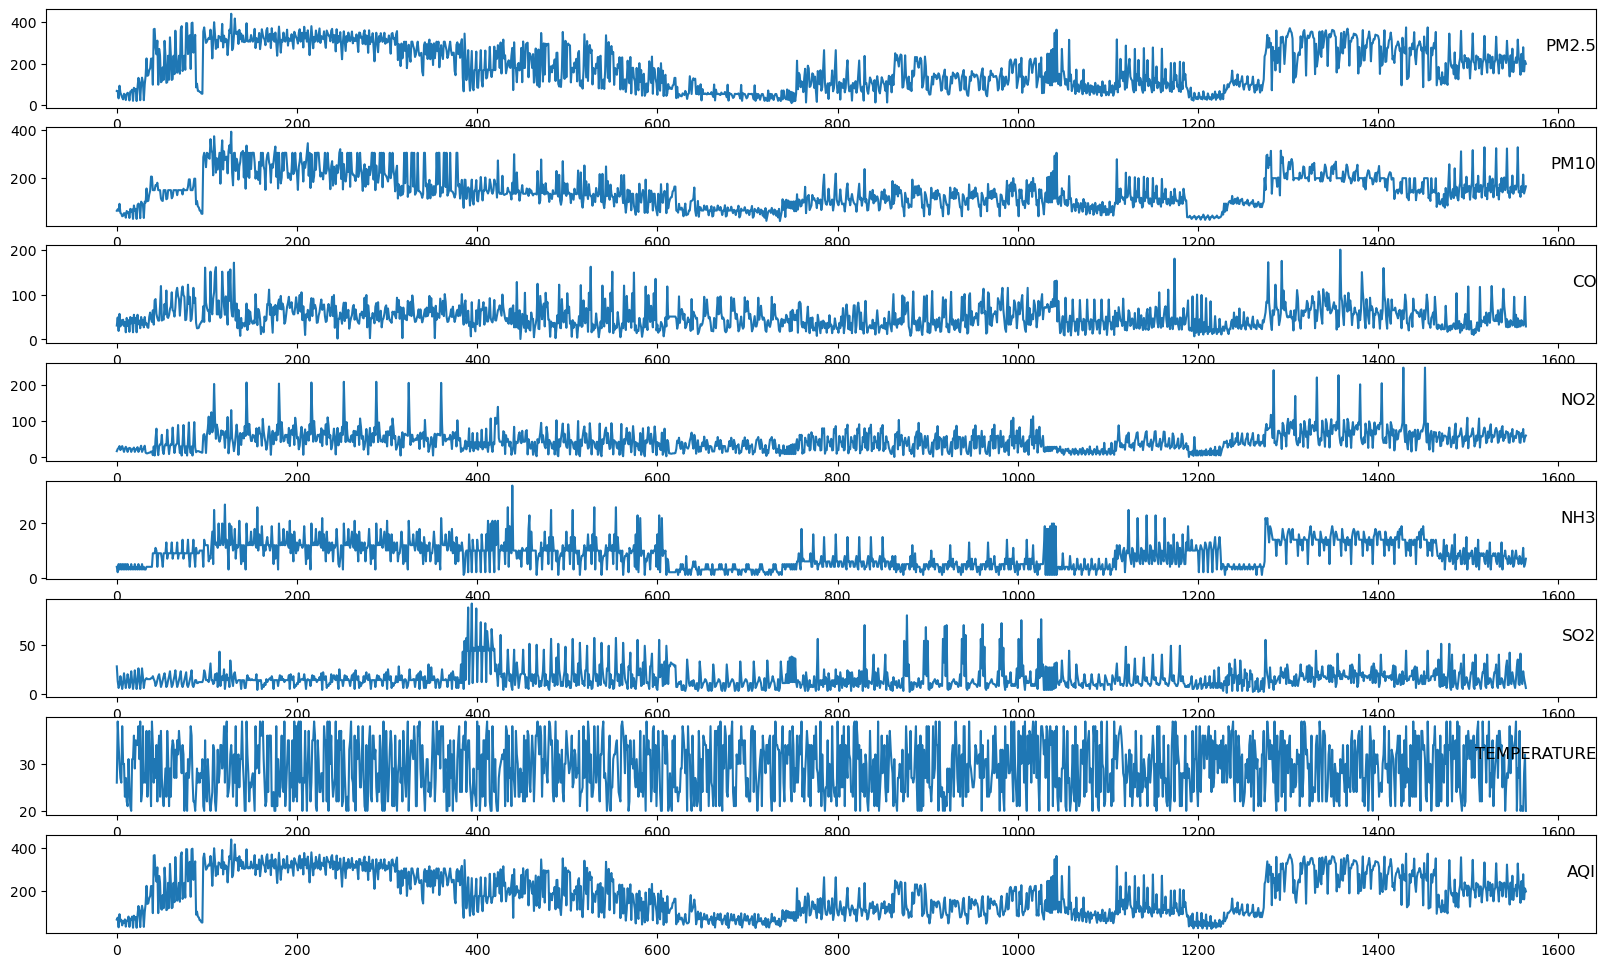

In [44]:
groups = ['PM2.5', 'PM10', 'CO', 'NO2', 'NH3', 'SO2', 'TEMPERATURE', 'AQI']
i = 1
# plot each column
plt.figure()
for group in groups:
    fig = plt.gcf()
    fig.set_size_inches(20, 12)
    plt.subplot(len(groups), 1, i)
    plt.plot(df[group])
    plt.title(group, y=0.5, loc='right')
    i += 1
plt.show()

In [45]:
# Load dataset again with datetime
df = pd.read_pickle("filteredDataAQ.pkl")

# Convert to datetime if needed
df["datetime"] = pd.to_datetime(df["datetime"])

# Set datetime as index
df = df.set_index("datetime")


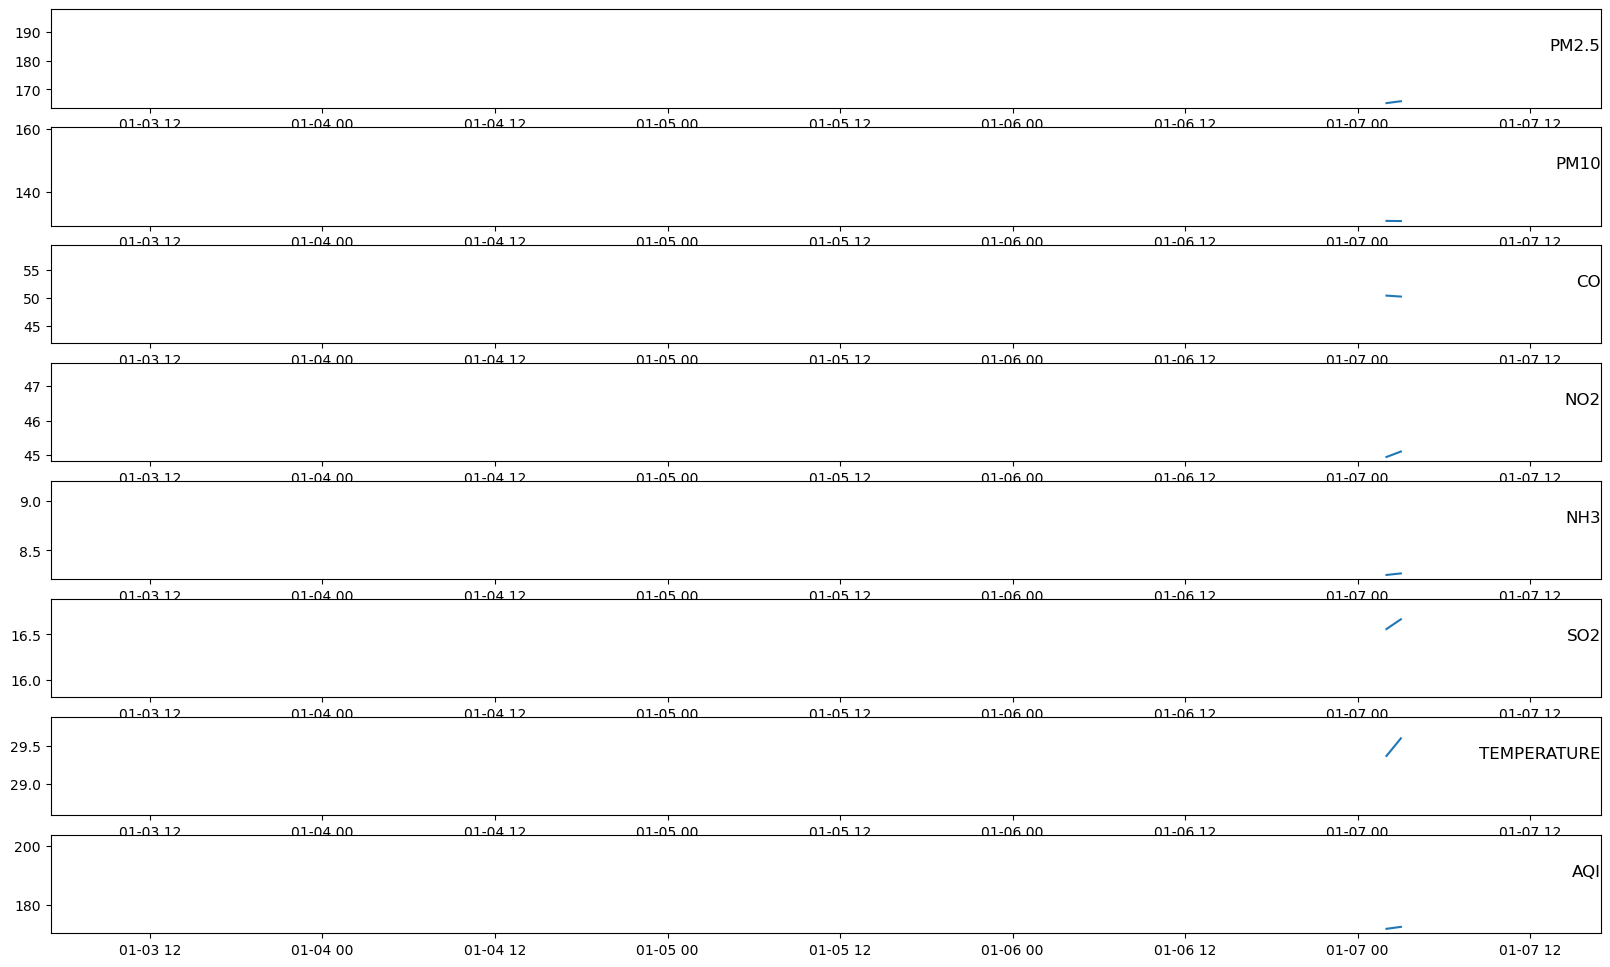

In [46]:
groups = ['PM2.5', 'PM10', 'CO', 'NO2', 'NH3', 'SO2', 'TEMPERATURE', 'AQI']
i = 1
# plot each column
plt.figure()
for group in groups:
    fig = plt.gcf()
    fig.set_size_inches(20, 12)
    plt.subplot(len(groups), 1, i)
    plt.plot(df[group].resample("h").mean())
    plt.title(group, y=0.5, loc='right')
    i += 1
plt.show()

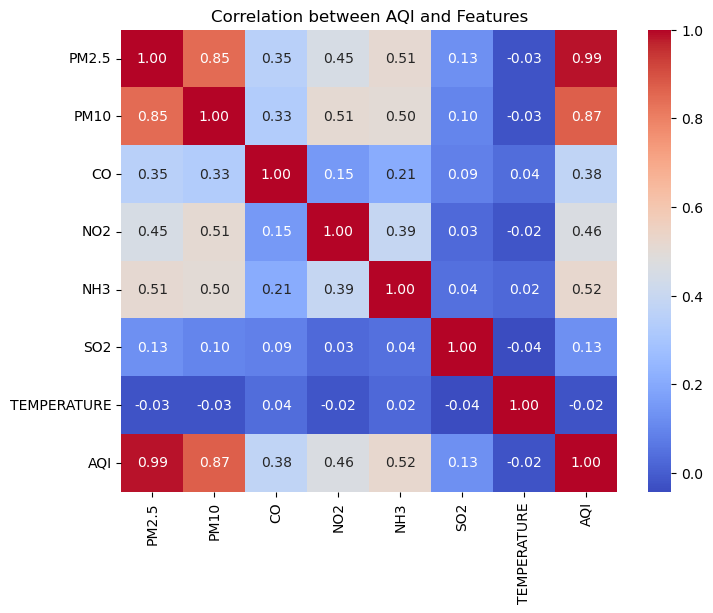

In [47]:
import seaborn as sns

plt.figure(figsize=(8,6))
sns.heatmap(df[groups].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation between AQI and Features")
plt.show()


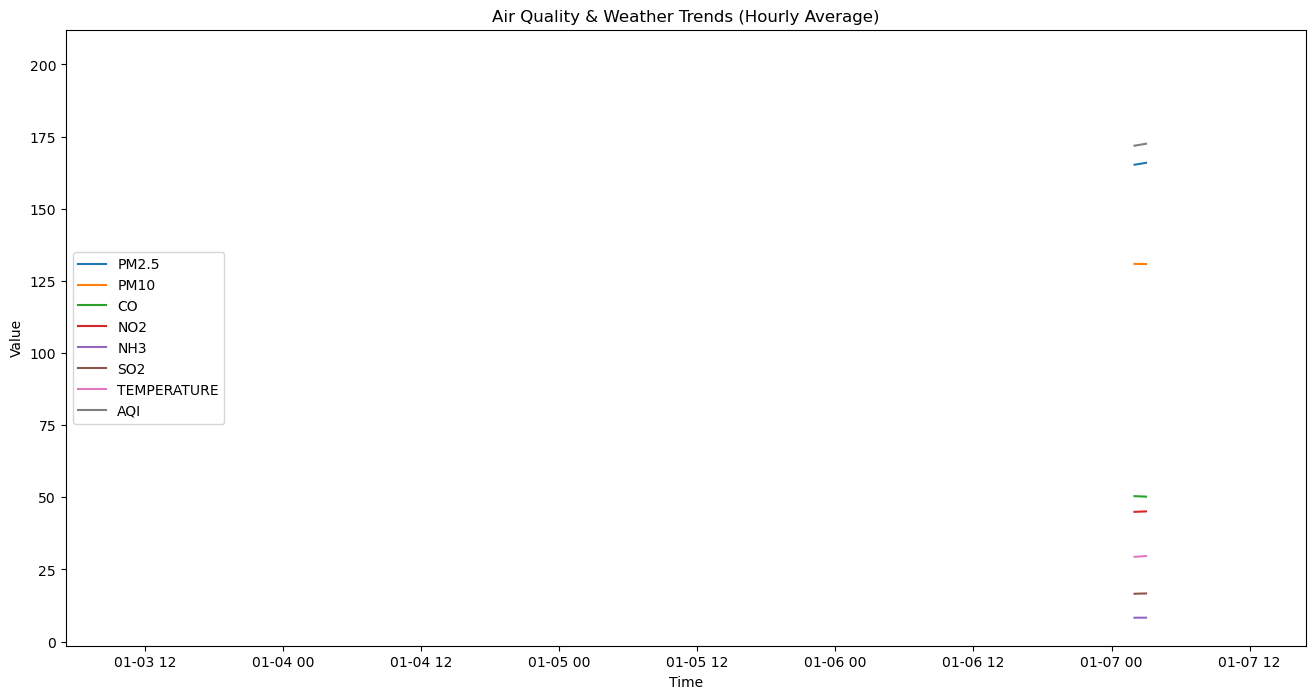

In [48]:
plt.figure(figsize=(16, 8))
for group in groups:
    plt.plot(df[group].resample("h").mean(), label=group)

plt.legend()
plt.title("Air Quality & Weather Trends (Hourly Average)")
plt.xlabel("Time")
plt.ylabel("Value")
plt.show()


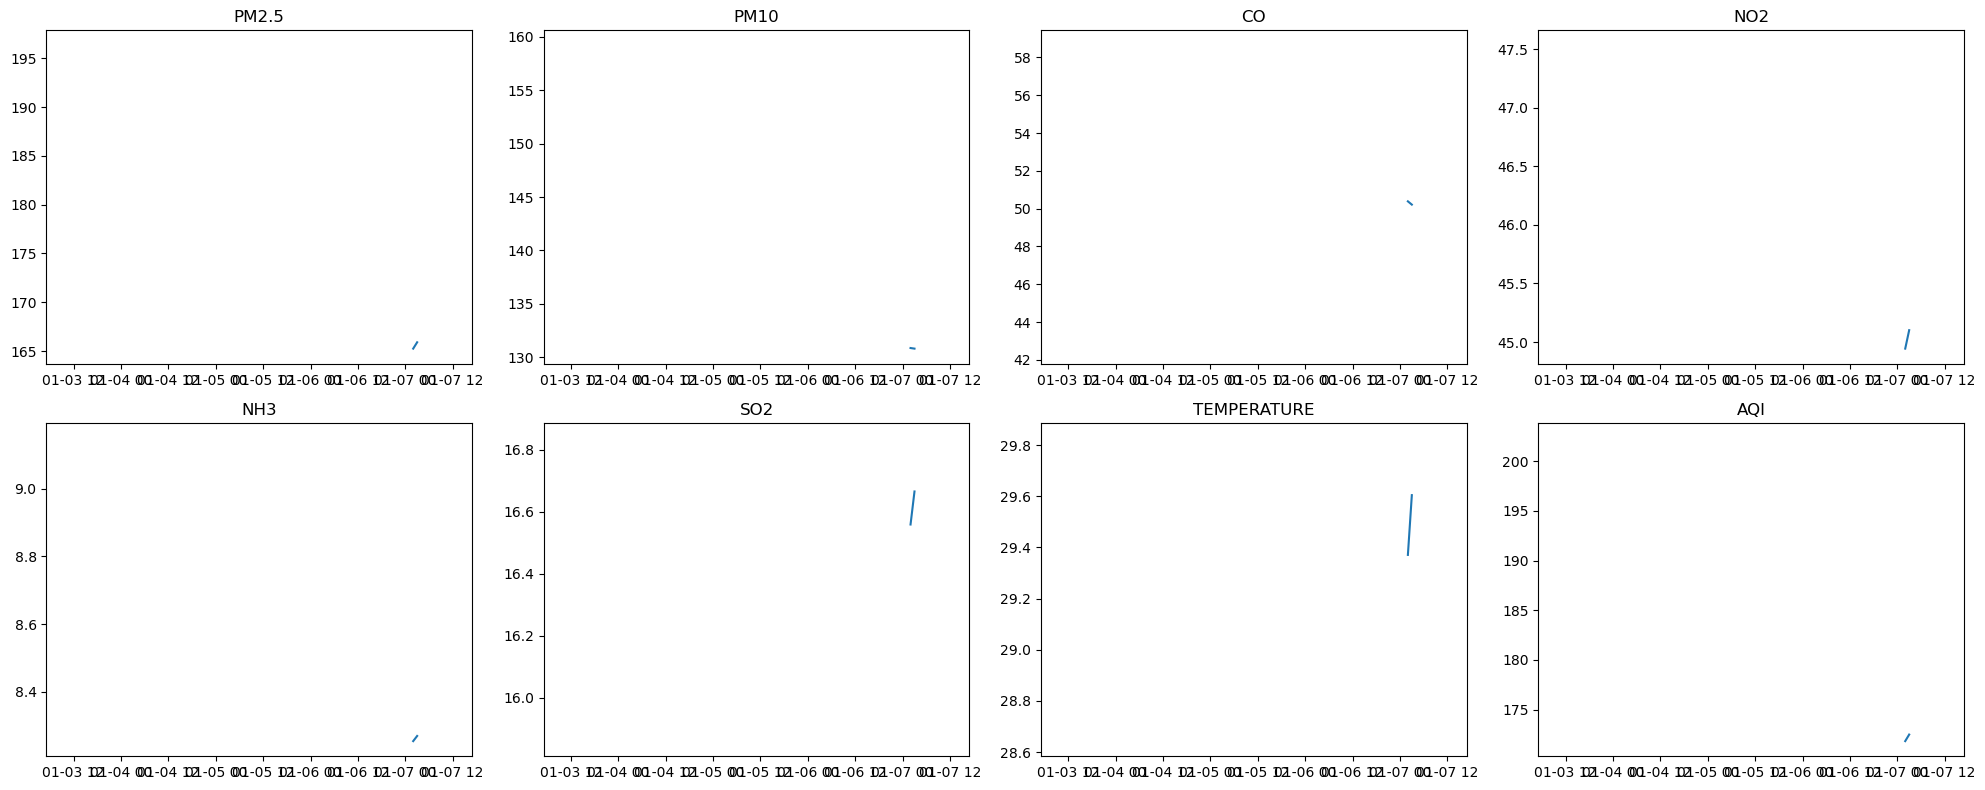

In [49]:
import matplotlib.pyplot as plt

groups = ['PM2.5', 'PM10', 'CO', 'NO2', 'NH3', 'SO2', 'TEMPERATURE', 'AQI']

fig, axes = plt.subplots(2, 4, figsize=(20, 8))  # 2 rows, 4 columns
axes = axes.flatten()

for i, group in enumerate(groups):
    axes[i].plot(df[group].resample("h").mean())
    axes[i].set_title(group)

plt.tight_layout()
plt.show()

### Time windowing dataset
**Series to supervised learning**

In [50]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
 n_vars = 1 if type(data) is list else data.shape[1]
 df = pd.DataFrame(data)
 cols, names = list(), list()
 # input sequence (t-n, ... t-1)
 for i in range(n_in, 0, -1):
     cols.append(df.shift(i))
     names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
 # forecast sequence (t, t+1, ... t+n)
 for i in range(0, n_out):
     cols.append(df.shift(-i))
     if i == 0:
         names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
     else:
         names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
 # put it all together
 agg = pd.concat(cols, axis=1)
 agg.columns = names
 # drop rows with NaN values
 if dropnan:
     agg.dropna(inplace=True)
 return agg

In [51]:
n_steps_in=1
n_steps_out=1

In [52]:
## resampling of data over hour
# keep only numeric columns
df_numeric = df.select_dtypes(include=['number'])

# resample by hour and take mean
df_resample = df_numeric.resample('h').mean()

K=df_resample.isna().sum(axis=1)>3
l=[]
for i in df_resample.index:
    if K[i]==True:
        l.append(i)
df_resample=df_resample.drop(l)

In [53]:
values = df_resample.values 

# integer encode direction
# encoder = LabelEncoder()
# values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, n_steps_in, n_steps_out)

# drop columns we don't want to predict
reframed.drop(reframed.columns[16:26].append(reframed.columns[27:]), axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.812301   1.000000   0.987162   1.000000   0.164948   1.000000   
2   1.000000   0.892613   0.609587   0.507028   0.000000   0.000000   
3   0.667365   0.717495   0.745533   0.303087   0.420198   0.589983   
4   0.748665   0.754190   1.000000   0.388458   0.691422   0.452876   
5   0.556739   0.557472   0.924379   0.294450   0.797615   0.677003   

   var7(t-1)  var8(t-1)  var9(t-1)  var10(t-1)  var11(t-1)  var12(t-1)  \
1   0.771988        0.0        0.0        0.00         0.8    0.524578   
2   1.000000        0.0        0.0        0.50         0.4    0.503757   
3   0.675553        0.0        0.0        0.75         0.1    0.000000   
4   0.762929        0.0        0.0        0.75         0.4    0.374722   
5   0.576890        0.0        0.0        0.75         0.9    1.000000   

   var13(t-1)  var14(t-1)   var1(t)   var2(t)  var13(t)  
1    0.409303    1.000000  1.000000  0.892613  0.566029  
2    0.56602

In [54]:
# split into train and test sets
values = reframed.values
n_train_hours = 10 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_Y = train[:, :-n_steps_out], train[:, -n_steps_out:]
test_X, test_Y = test[:, :-n_steps_out], test[:, -n_steps_out:]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_steps_in, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], n_steps_in, test_X.shape[1]))
#train_Y = train_Y.reshape((train_X.shape[0], n_steps_in, train_X.shape[1]))
#test_Y = test_Y.reshape((test_X.shape[0], n_steps_in, test_X.shape[1]))

print(train_X.shape, train_Y.shape, test_X.shape, test_Y.shape)

(7, 1, 16) (7, 1) (0, 1, 16) (0, 1)


In [55]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_Y, epochs=50, batch_size=72, validation_data=(test_X, test_Y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

Epoch 1/50


C:\Users\LENOVO\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 - 3s - 3s/step - loss: 0.6903
Epoch 2/50
1/1 - 0s - 145ms/step - loss: 0.6691
Epoch 3/50


C:\Users\LENOVO\anaconda3\Lib\site-packages\keras\src\trainers\epoch_iterator.py:164: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 - 0s - 167ms/step - loss: 0.6538
Epoch 4/50
1/1 - 0s - 117ms/step - loss: 0.6386
Epoch 5/50
1/1 - 0s - 116ms/step - loss: 0.6234
Epoch 6/50
1/1 - 0s - 137ms/step - loss: 0.6082
Epoch 7/50
1/1 - 0s - 134ms/step - loss: 0.5928
Epoch 8/50
1/1 - 0s - 136ms/step - loss: 0.5774
Epoch 9/50
1/1 - 0s - 121ms/step - loss: 0.5618
Epoch 10/50
1/1 - 0s - 118ms/step - loss: 0.5462
Epoch 11/50
1/1 - 0s - 124ms/step - loss: 0.5304
Epoch 12/50
1/1 - 0s - 117ms/step - loss: 0.5145
Epoch 13/50
1/1 - 0s - 124ms/step - loss: 0.4984
Epoch 14/50
1/1 - 0s - 119ms/step - loss: 0.4821
Epoch 15/50
1/1 - 0s - 123ms/step - loss: 0.4657
Epoch 16/50
1/1 - 0s - 114ms/step - loss: 0.4490
Epoch 17/50
1/1 - 0s - 117ms/step - loss: 0.4321
Epoch 18/50
1/1 - 0s - 137ms/step - loss: 0.4150
Epoch 19/50
1/1 - 0s - 125ms/step - loss: 0.3976
Epoch 20/50
1/1 - 0s - 126ms/step - loss: 0.3883
Epoch 21/50
1/1 - 0s - 122ms/step - loss: 0.3810
Epoch 22/50
1/1 - 0s - 117ms/step - loss: 0.3737
Epoch 23/50
1/1 - 0s - 125ms/step - lo

NameError: name 'pyplot' is not defined

In [ ]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_Y = test_Y.reshape((len(test_Y), 1))
inv_y = concatenate((test_Y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

In [ ]:
# Serialize mlp_nn object into a file called mlp_nn.pkg on disk using pickle
with open('lstmModel.pkl', 'wb') as handle:
    pickle.dump(model, handle, pickle.HIGHEST_PROTOCOL)
    

In [ ]:
# de-serialize mlp_nn.pkl file into an object called mlp_nn using pickle
with open('lstmModel.pkl', 'rb') as handle:
    lstmModel = pickle.load(handle) 

Creating time-based features...
Using features: ['PM2.5', 'PM10', 'NO2', 'NH3', 'SO2', 'CO', 'TEMPERATURE', 'HUMIDITY', 'ALTITUDE', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'month_sin', 'month_cos', 'Year', 'Month', 'Day', 'Hour']
Target: AQI
Created sequences: X shape (1517, 48, 19), y shape (1517,)
Training set: (1213, 48, 19), Test set: (304, 48, 19)


C:\Users\LENOVO\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_7 (LSTM)                        │ (None, 48, 64)              │          21,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 48, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_8 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 34,465 (134.63 KB)

 Trainable params: 34,465 (134.63 KB)

 Non-trainable params: 0 (0.00 B)

None
Training model...
Epoch 1/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 15s 130ms/step - loss: 0.0672 - mae: 0.2066 - val_loss: 0.0309 - val_mae: 0.1482
Epoch 2/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 92ms/step - loss: 0.0274 - mae: 0.1282 - val_loss: 0.0271 - val_mae: 0.1366
Epoch 3/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - loss: 0.0241 - mae: 0.1188 - val_loss: 0.0239 - val_mae: 0.1231
Epoch 4/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 0.0233 - mae: 0.1172 - val_loss: 0.0249 - val_mae: 0.1279
Epoch 5/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 0.0212 - mae: 0.1119 - val_loss: 0.0233 - val_mae: 0.1210
Epoch 6/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 0.0221 - mae: 0.1133 - val_loss: 0.0234 - val_mae: 0.1221
Epoch 7/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - loss: 0.0194 - mae: 0.1073 - val_loss: 0.0286 - val_mae: 0.1414
Epoch 8/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 0.0201 - mae: 0.1080 - val_loss: 0.0252 - val_mae: 0.1295
Epoch 9/100
38/38 ━━━━━━━━━━━━━

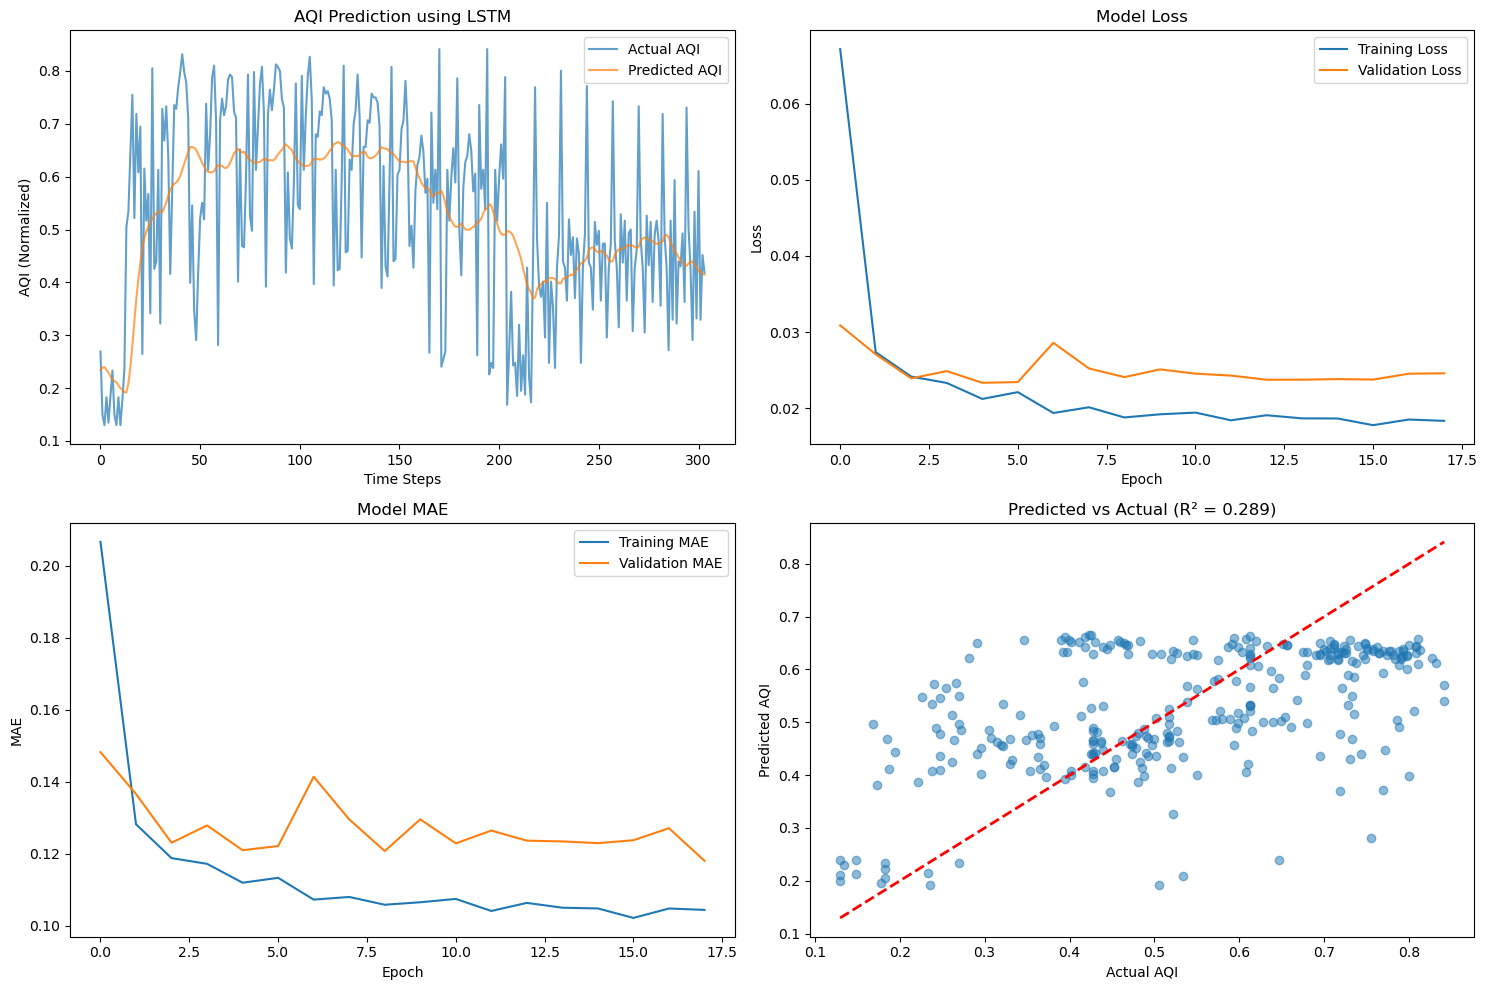


Feature Importance Analysis:
Features used: ['PM2.5', 'PM10', 'NO2', 'NH3', 'SO2', 'CO', 'TEMPERATURE', 'HUMIDITY', 'ALTITUDE', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'month_sin', 'month_cos', 'Year', 'Month', 'Day', 'Hour']
Model saved as 'aqi_lstm_model.h5'

Sample predictions:
Actual: 0.269, Predicted: 0.234
Actual: 0.149, Predicted: 0.239
Actual: 0.130, Predicted: 0.240
Actual: 0.183, Predicted: 0.235
Actual: 0.135, Predicted: 0.230


In [60]:
# Add these imports at the top
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
import numpy as np

# After checking your DataFrame columns, add time-based features
print("Creating time-based features...")
# Add cyclic time features
df['hour_sin'] = np.sin(2 * np.pi * df['Hour']/24)
df['hour_cos'] = np.cos(2 * np.pi * df['Hour']/24)
df['day_sin'] = np.sin(2 * np.pi * df['Day']/31)
df['day_cos'] = np.cos(2 * np.pi * df['Day']/31)
df['month_sin'] = np.sin(2 * np.pi * df['Month']/12)
df['month_cos'] = np.cos(2 * np.pi * df['Month']/12)

# Update features list to include temporal features
available_features = ['PM2.5', 'PM10', 'NO2', 'NH3', 'SO2', 'CO', 'TEMPERATURE', 'HUMIDITY', 'ALTITUDE',
                     'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'month_sin', 'month_cos', 'Year', 'Month', 'Day', 'Hour']

# Only use features that actually exist in the dataframe
features = [col for col in available_features if col in df.columns]
target = 'AQI'

print("Using features:", features)
print("Target:", target)

# 3. Normalize the data (keep this part the same)
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[features + [target]])

# 4. Create sequences for LSTM (keep this the same)
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i, :-1])  # All features except target
        y.append(data[i, -1])  # Target variable (AQI)
    return np.array(X), np.array(y)

SEQ_LENGTH = 48  # Increased to 48 hours for better temporal context
X, y = create_sequences(scaled_data, SEQ_LENGTH)


print(f"Created sequences: X shape {X.shape}, y shape {y.shape}")

# 5. Split data temporally (important for time series!)
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"Training set: {X_train.shape}, Test set: {X_test.shape}")

# 6. Build LSTM model
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.3),
    LSTM(32, return_sequences=False),
    Dropout(0.3),
    Dense(16, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

print(model.summary())

# 7. Train the model
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=15, 
    restore_best_weights=True,
    min_delta=0.001
)

print("Training model...")
history = model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=100,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping],
    verbose=1
)

# 8. Evaluate the model
train_loss, train_mae = model.evaluate(X_train, y_train, verbose=0)
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)

print(f"\nModel Evaluation:")
print(f"Train MSE: {train_loss:.4f}, Train MAE: {train_mae:.4f}")
print(f"Test MSE: {test_loss:.4f}, Test MAE: {test_mae:.4f}")

# Calculate additional metrics
from sklearn.metrics import r2_score
predictions = model.predict(X_test)
r2 = r2_score(y_test, predictions)
print(f"R² Score: {r2:.4f}")

# 9. Plot results
plt.figure(figsize=(15, 10))

# Plot actual vs predicted
plt.subplot(2, 2, 1)
plt.plot(y_test, label='Actual AQI', alpha=0.7)
plt.plot(predictions, label='Predicted AQI', alpha=0.7)
plt.title('AQI Prediction using LSTM')
plt.xlabel('Time Steps')
plt.ylabel('AQI (Normalized)')
plt.legend()

# Plot training history - Loss
plt.subplot(2, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training history - MAE
plt.subplot(2, 2, 3)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

# Scatter plot of predictions vs actual
plt.subplot(2, 2, 4)
plt.scatter(y_test, predictions, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual AQI')
plt.ylabel('Predicted AQI')
plt.title(f'Predicted vs Actual (R² = {r2:.3f})')

plt.tight_layout()
plt.show()

# 10. Feature importance analysis (optional)
print("\nFeature Importance Analysis:")
print("Features used:", features)

# Save the model
model.save('aqi_lstm_model.h5')
print("Model saved as 'aqi_lstm_model.h5'")

# Show some sample predictions
print("\nSample predictions:")
for i in range(5):
    print(f"Actual: {y_test[i]:.3f}, Predicted: {predictions[i][0]:.3f}")